- *It works!*
- DONE: use `max_batchsize` from `utils`
- DONE: make **dedicated notebook** to (i) compare `conll2003` to `fewnerd` and (ii) to bring `fewnerd` into the same format.
- DONE: use fewnerd
- DONE: get total flops count with **einops**
- DONE: make custom splits
- DONE: reorder the notebook cells:
  - DONE: model (LoRA) and tokenizer (save peftconfig if necessary)
  - DONE: dataset etc
  - DONE: training, metrics and saving (tokenizer and model)
  - DONE: inference via loading saved items (probably tokenizer, model and peftconfig – OR follow this [guide](https://huggingface.co/docs/peft/v0.9.0/en/package_reference/lora#peft.LoraModel))
- DONE: In **Using the fine-tuned model**, [merge and unload](https://huggingface.co/docs/peft/v0.6.2/en/package_reference/tuners#peft.LoraModel.merge_and_unload) or [reinstantiate](https://huggingface.co/docs/peft/v0.6.2/en/task_guides/token-classification-lora#inference) the LoRA model!
- DONE: adjust batch size – and if necessary epochs – for 3000 training steps `num_steps = train_instances*epochs/batch_size` $\geq$ 3000 $\Rightarrow$ `batch_size` $\leq$ `train_instances*epochs/3000 = train_instances/1000` $\Rightarrow$ `batch_size` $\leq$ `train_instances / 1000` for `epochs = 3`<br>DONE: But do it like this:
  - DONE: get max batch size for model (= max_batchsize_by_model)
  - DONE: specify trainig split
  - DONE: get max batch size for training split length (=max_batchsize_by_trainsplit)
  - DONE: impose max batch size of 32
  - DONE: the batch size is the minimum of these three numbers
- DONE: build `results.json` (consider pandas series) via dict. It holds: splits, specified loraconfig details, flops, metrics (per epoch)
- DONE: use the uuid library to save `results.json` under `results_{uuid}.json`
- DONE: declare variable `split` and use it to select splits as well as for logging it in `results_{uuid}.json`.
- DONE: use split `dev` and determine the learning rate for LoRA models. It seems that with `accelerate`, the maximum accepted learning rate is `5e-4` since fails for higher learning rates.
- DONE: outside the training loop make a dummy classification report using scikit-learn with dummy labels and dummy predictions (both formatted as required by classification report)
- DONE: at the end of each epoch, bring the labels and predictions into the required format
- DONE: write a compute metrics function that returns a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) as dict, then log the relevant values
- DONE: drop the `uuid` from the `logs_dict` filename as it only adds ambiguity about what file to look at.
- DONE: Use both `macro` and `weighted` metrics.
- DONE: Specify `output_dir` with `spec` (e.g. `ner_logs/fb-roberta/{spec}`) for saving `logs_dict.json` and `confusion_matrix.png`:
  - DONE: pattern: `task/model/spec/*files_with_vanilla_names*`
  - DONE: example: `ner_logs/FacebookAI-roberta-large/split=dev__r=64__bias=lora_only__loradroput=0point2/logs_dict.json`
- DONE: Add confusion matrix
  - DONE: save percentage version
  - DONE: save vanilla version
- DONE: Save `logs_dict.json` and `confusion_matrix.png`.
- DONE: keep original ner labels (IOB2 would result in 2*n-1 labels instead of n labels – but due to sparse labels, the dataset is already difficult enough)
- DONE: filter out long instances with 80 words or more $\Rightarrow$ remove 0.3384% of training instances (negligible).
- Drop accelerate and use basic torch loop as in `roberta-base-ner_LoRA_cells.ipynb` (make a copy of that other notebook and adapt it to this one.
- Pick a not too long instance from `fewnerd_all_processed` and show token - label pairs (as for inference).
- Handle and log both `roberta-large` and `roberta-base` (adapt `batch_size_dict`).
- Check once more the wandb [ablation study](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) on batch sizes!
- check everything once more
- add comments
- make new notebook copy for sweep

# NER with `fewnerd` and LoRA

In [1]:
import os
import re
import json
import time
import torch
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
from utils import set_seed, make_confusion_matrix
from dotenv import load_dotenv
from datasets import load_dataset, concatenate_datasets, DatasetDict
from evaluate import load
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler, pipeline, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from huggingface_hub import login
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from deepspeed.profiling.flops_profiler import FlopsProfiler

load_dotenv()
login(token=os.getenv("HUGGINGFACE_API_KEY"))
logs_dict = {}
logs_dict["seed"] = set_seed(42)

[2024-03-23 01:03:28,918] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/matthias/.cache/huggingface/token
Login successful
All random seeds set to 42.


## Model

In [2]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
print(label_names)
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']


({'0': 'O',
  '1': 'art',
  '2': 'building',
  '3': 'event',
  '4': 'location',
  '5': 'organization',
  '6': 'other',
  '7': 'person',
  '8': 'product'},
 {'O': '0',
  'art': '1',
  'building': '2',
  'event': '3',
  'location': '4',
  'organization': '5',
  'other': '6',
  'person': '7',
  'product': '8'})

In [3]:
model_version = "base" # "base" or "large"
model_id = f"FacebookAI/roberta-{model_version}" # "FacebookAI/roberta-base" or "FacebookAI/roberta-large"
logs_dict["model_id"] = model_id
model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
# LoRA model
# datasets:      3 values [1%, 10%, 100%]
# lora_rank:    10 values [1, ..., 512]
# lora_dropout:  5 values [0, 0.1, 0.2, 0.3, 0.4]
# lora_bias:     3 values ["all", "none", "lora_only"]
# => 3 x 10 x 5 x 3 = 450 sweeps per notebook (of which 45 have rank 512 and thus take 45*3.75h=168.75 > 168h=7*24h => a bit over two weeks
# => start with 2 dataset values (10%, 100%) and 3 rank values (2, 8, 32) => 6 sweeps
LoRA_params_dict = {
    "r": 2,
    "target_modules": ["query", "key", "value", "query_proj", "key_proj", "value_proj"],
    "bias": "all",
    "use_rslora": True,
    "task_type": TaskType.TOKEN_CLS,
    "lora_dropout": 0.2
}
logs_dict["LoRA_params_dict"] = LoRA_params_dict
# r =   1 => (  156681, 354476050, 0.00044)
# r =   2 => (  304137, 354623506, 0.00086)
# r =   4 => (  599049, 354918418, 0.00169)
# r =   8 => ( 1188873, 355508242, 0.00334)
# r =  16 => ( 2368521, 356687890, 0.00664)
# r =  32 => ( 4727817, 359047186, 0.01317)
# r =  64 => ( 9446409, 363765778, 0.02597)
# r = 128 => (18883593, 373202962, 0.0506)
# r = 256 => (37757961, 392077330, 0.0963)
# r = 512 => (75506697, 429826066, 0.17567)
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = LoRA_params_dict["r"],
    target_modules=LoRA_params_dict["target_modules"],
    bias=LoRA_params_dict["bias"],
    use_rslora=LoRA_params_dict["use_rslora"],
    task_type=LoRA_params_dict["task_type"],
    lora_dropout=LoRA_params_dict["lora_dropout"]
)
logs_dict["LoraConfig"] = str(config)
print(f"LoRA config:\n{config}\n")
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
print(f"base_model type:\n{type(model)}")
print(f"\nadapter_model type:\n{type(model)}")
trainable_params, all_params = model.get_nb_trainable_parameters()
trainable_fraction = round(trainable_params/all_params, 5)
logs_dict["LoRA_model_trainable_params"] = trainable_params
logs_dict["LoRA_model_all_params"] = all_params
logs_dict["LoRA_model_trainable_fraction"] = trainable_fraction
print(f"\ntrainable parameters:\n{trainable_params}")
print(f"\nall parameters:\n{all_params}")
print(f"\ntrainable fraction:\n{trainable_fraction}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA config:
LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=2, target_modules={'value_proj', 'key_proj', 'key', 'value', 'query_proj', 'query'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

base_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

adapter_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

trainable parameters:
219657

all parameters:
124179474

trainable fraction:
0.00177


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
logs_dict["tokenizer"] = model_id
print(f"tokenizer is fast: {tokenizer.is_fast}")
tokenizer

tokenizer is fast: True


RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

## Dataset

In [5]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 131767
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 18824
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 37648
    })
})

In [6]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

fewnerd_all_processed = (
    concatenate_datasets([raw_datasets["train"], raw_datasets["validation"], raw_datasets["test"]])
    # pre-tokenization, the "tokens" column contains words (not tokens)
    #.filter(lambda example: len(example["tokens"])<=30) # 80 (roberta-large) => from 188239 to 187602 (637 instances or 0.3384% removed)
    .map(                                               # 50 (roberta-base) => from 188239 to 181338 (...)
        tokenize_and_align_labels,                      # 30 (roberta-base) => from 188239 to 141195 (...)
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )
)
fewnerd_all_processed

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 188239
})

In [7]:
# filter dataset by length if necessary
trainvalid_test_splits = fewnerd_all_processed.train_test_split(test_size=0.15)
test_split_100 = trainvalid_test_splits["test"]
test_split_10 = test_split_100.train_test_split(test_size = 0.1)["test"]
test_split_1 = test_split_100.train_test_split(test_size = 0.01)["test"]
trainvalid_split = trainvalid_test_splits["train"]
train_valid_split = trainvalid_split.train_test_split(test_size=0.15)
valid_split_100 = train_valid_split["test"]
valid_split_10 = valid_split_100.train_test_split(test_size = 0.1)["test"]
valid_split_1 = valid_split_100.train_test_split(test_size = 0.01)["test"]
train_split_100 = train_valid_split["train"]
train_split_10 = train_split_100.train_test_split(test_size = 0.1)["test"]
train_split_1 = train_split_100.train_test_split(test_size = 0.01)["test"]
dev_train_split = train_split_100.train_test_split(test_size = 120)["test"]
dev_valid_split = valid_split_100.train_test_split(test_size = 32)["test"]
dev_test_split = test_split_100.train_test_split(test_size = 8)["test"]
fewnerd_dsd = DatasetDict({
    "train_100": train_split_100,
    "train_10": train_split_10,
    "train_1": train_split_1,
    "valid_100": valid_split_100,
    "valid_10": valid_split_10,
    "valid_1": valid_split_1,
    "test_100": test_split_100,
    "test_10": test_split_10,
    "test_1": test_split_1,
    "train_dev": dev_train_split,
    "valid_dev": dev_valid_split,
    "test_dev": dev_test_split
})
fewnerd_dsd

DatasetDict({
    train_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 136002
    })
    train_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13601
    })
    train_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1361
    })
    valid_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 24001
    })
    valid_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2401
    })
    valid_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 241
    })
    test_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28236
    })
    test_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2824
    })
    test_1: Dataset({
        features: ['input_ids', 'attentio

In [8]:
split = "dev" # "100", "10", "1", "dev"
assert split in ("100", "10", "1", "dev"), f"Split '{split}' is not a valid choice."
train_split = f"train_{split}"
valid_split = f"valid_{split}"
test_split = f"test_{split}"
train_split, valid_split, test_split

('train_dev', 'valid_dev', 'test_dev')

In [9]:
spec = f"split={split}"
spec += f"__r={LoRA_params_dict['r']}"
spec += f"__bias={LoRA_params_dict['bias']}"
spec += f"__loradroput=0point{str(LoRA_params_dict['lora_dropout'])[2:]}"
model_folder = re.sub("/", "-", model_id)
output_dir = f"ner_logs/{model_folder}/{spec}"
output_dir

'ner_logs/FacebookAI-roberta-base/split=dev__r=2__bias=all__loradroput=0point2'

## Training

In [10]:
batchsize_dict = {
    # values have been found manually via trial and error
    # batch size rules: (i) as large as possible, (ii) 1000 steps per epoch, (iii) 32 max
    "base": {
        "100": 1,
        "10": 1,
        "1": 1,
        "dev": 1
    },
    "large": {
        "100": 32, # OK: 32, max: 128
        "10": 8,
        "1": 1,
        "dev": 1
    }
}
batch_size = batchsize_dict[model_version][split]
batch_size

1

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch: 1, Step: 0, Loss: 1.9522875547409058
Epoch: 1, Step: 10, Loss: 2.048769235610962
Epoch: 1, Step: 20, Loss: 1.934207797050476
Epoch: 1, Step: 30, Loss: 2.035865545272827
Epoch: 1, Step: 40, Loss: 1.967837929725647
Epoch: 1, Step: 50, Loss: 1.9449756145477295
Epoch: 1, Step: 60, Loss: 1.7927262783050537
Epoch: 1, Step: 70, Loss: 1.8611564636230469
Epoch: 1, Step: 80, Loss: 1.9299639463424683
Epoch: 1, Step: 90, Loss: 1.7866222858428955
Epoch: 1, Step: 100, Loss: 1.645293951034546
Epoch: 1, Step: 110, Loss: 1.6369601488113403
Epoch: 2, Step: 0, Loss: 1.559438943862915
Epoch: 2, Step: 10, Loss: 1.6344174146652222
Epoch: 2, Step: 20, Loss: 1.8632876873016357
Epoch: 2, Step: 30, Loss: 1.8782882690429688
Epoch: 2, Step: 40, Loss: 1.6700845956802368
Epoch: 2, Step: 50, Loss: 1.7492666244506836
Epoch: 2, Step: 60, Loss: 1.609822392463684
Epoch: 2, Step: 70, Loss: 1.879076600074768
Epoch: 2, Step: 80, Loss: 1.3372517824172974
Epoch: 2, Step: 90, Loss: 1.7075450420379639
Epoch: 2, Step: 10

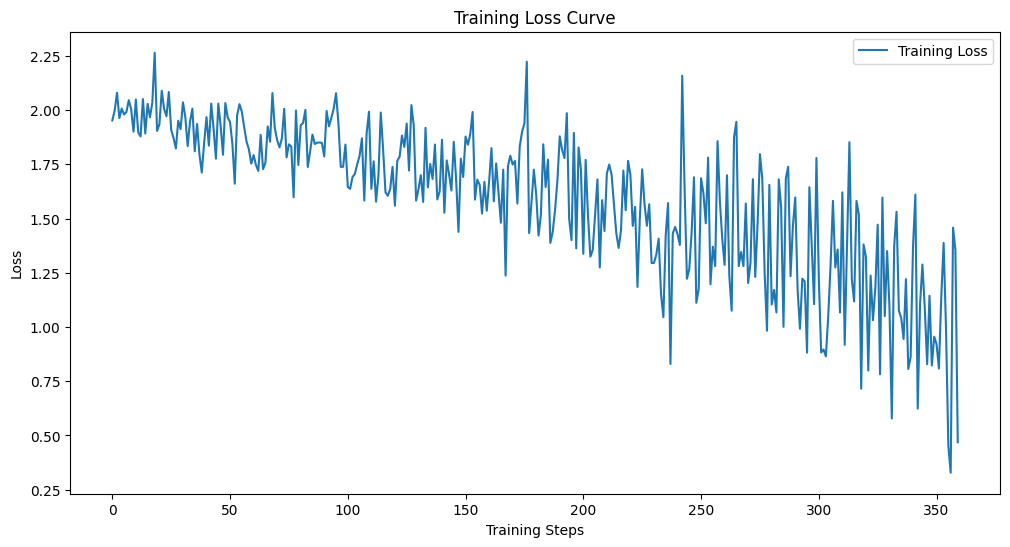

In [12]:
# Setup DataLoader
train_dataloader = DataLoader(fewnerd_dsd[train_split], shuffle=True, batch_size=1, collate_fn=data_collator)

# Prepare for training with the Accelerate library
accelerator = Accelerator()
optimizer = AdamW(model.parameters(), lr=1e-5)

model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

# Initialize the list to store loss values
loss_values = []

# Training loop
for epoch in range(3):  # Adjust the number of epochs as needed
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**{k: v.to(accelerator.device) for k, v in batch.items()})
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        loss_values.append(accelerator.gather(loss.repeat(1)).mean().item())
        if step % 10 == 0:
            print(f"Epoch: {epoch + 1}, Step: {step}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [13]:

# Load the model configured for NER with the appropriate number of labels
model = AutoModelForTokenClassification.from_pretrained('roberta-base', num_labels=len(dataset["train"].features["ner_tags"].feature.names))

# peft model
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = 2,
    target_modules=["query", "key", "value"],
    bias="all",
    use_rslora=True,
    task_type=TaskType.TOKEN_CLS,
    lora_dropout=0.1
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
type(model)

NameError: name 'dataset' is not defined

In [ ]:
# Setup DataLoader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=1, collate_fn=data_collator)

# Prepare for training with the Accelerate library
accelerator = Accelerator()
optimizer = AdamW(model.parameters(), lr=1e-5)

model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

# Initialize the list to store loss values
loss_values = []

# Training loop
for epoch in range(3):  # Adjust the number of epochs as needed
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**{k: v.to(accelerator.device) for k, v in batch.items()})
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        loss_values.append(accelerator.gather(loss.repeat(1)).mean().item())
        if step % 10 == 0:
            print(f"Epoch: {epoch + 1}, Step: {step}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()